In [1]:
# default_exp helpers

In [2]:
# hide
%load_ext autoreload
%autoreload 2

In [3]:
# hide
from nbdev import *
from IPython.display import display

In [4]:
#exporti

import pandas as pd
from typing import Union

try:
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable


def flatten(lis):
    for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:
            yield item

In [5]:
# hide
assert (list(flatten([1, 2, [3, 4, 5, [6, 7]], 8, [9, 10]])) == list(range(1, 11)))

In [6]:
# hide
list(flatten([1, 2, [3, 4], 5]))

[1, 2, 3, 4, 5]

# Helpers

Module to add utils for other modules.

In [7]:
#exporti
import textwrap

from PIL import Image, ImageDraw, ImageFont


def text_on_img(text="Hello", lbl_w=None, lbl_h=None, font_size=14, filepath=None):
    """
        Render text in a image
    """

    font = ImageFont.truetype("lte50712.ttf", font_size)

    if lbl_w is None:
        lbl_w = 150
    if lbl_h is None:
        lbl_h = 150

    assert(text)

    text = text.upper()

    m_width, m_heigth = font.getsize("M")
    char_num_per_line = lbl_w // m_width

    image = Image.new(mode="RGB", size=(lbl_w, lbl_h), color="white")
    draw = ImageDraw.Draw(image)

    words = text.split()
    if len(words) <= 2 and all(font.getsize(w)[0] < lbl_w for w in words):
        t_wrapper = words
    else:
        t_wrapper = textwrap.wrap(text, char_num_per_line)

    offset = (lbl_h - (m_heigth * len(t_wrapper))) // 2

    for line in t_wrapper:
        line_w, line_h = font.getsize(line)
        draw.text(((lbl_w - line_w) // 2, offset), line, font=font, fill=(0, 0, 0))
        offset += line_h

    if filepath:
        image.save(filepath)

    return image

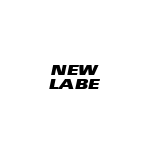

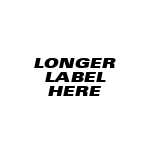

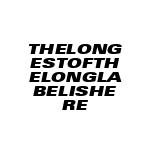

In [8]:
# hide
display(text_on_img(text="new labe"))
display(text_on_img(text="longer label here"))
display(text_on_img(text="thelongestofthelonglabelishere"))

In [9]:
#exporti
import json
import os
import re


def reconstruct_class_images(label_dir, annotation_file, lbl_w=None, lbl_h=None):
    with open(annotation_file) as json_file:
        data = json.load(json_file)
        unique_classes = set(flatten(data.values()))  # ipyannotator format

    for cl_name in unique_classes:
        if cl_name is None:
            cl_name = "None"

        cl_im_name = f'{cl_name}.jpg' if not re.findall(r"([-\w]+\.(?:jpg|png|jpeg))",
                                                        cl_name, re.IGNORECASE) else cl_name

        text_on_img(text=os.path.splitext(cl_name)[0], filepath=label_dir / cl_im_name,
                    lbl_w=lbl_w, lbl_h=lbl_h)

In [10]:
# hide
import tempfile
tmp_dir = tempfile.TemporaryDirectory()

fol = Path(tmp_dir.name) / 'autogenerated'
fol.mkdir(parents=True, exist_ok=True)

annotations = {
    str(Path(tmp_dir.name) / 'img_0.jpg'): ['yellow.jpg'],
    str(Path(tmp_dir.name) / 'img_1.jpg'): ['red'],
    str(Path(tmp_dir.name) / 'img_2.jpg'): ['red']
}

annot_file = Path(tmp_dir.name) / 'annotations.json'
with open(annot_file, 'w') as f:
    json.dump(annotations, f, indent=2)

reconstruct_class_images(fol, annot_file)

In [11]:
#hide
#check if generated
os.listdir(fol)

['yellow.jpg', 'red.jpg']

In [12]:
#exporti
import numpy as np


def augment(sig):
    s = (sig[2] + sig[3]) // 2
    return (sig + (np.random.rand(1, 4) * s - s / 2)).astype(int).tolist()[0]

In [13]:
augment(np.array([10, 10, 10, 10]))

[12, 6, 10, 12]

In [14]:
#export

from random import choice
from ipyannotator.datasets.factory import DS as NDS
from ipyannotator.datasets.factory_legacy import DS, _combine_train_test
from pathlib import Path
from tqdm.notebook import tqdm


class Tutorial:
    """
    Combines some algorithms to imitate human work with annotators

    """

    def __init__(self, dataset: Union[DS, NDS], project_path):
        self.dataset = dataset
        self.project_path = project_path
        if self.dataset not in [DS.ARTIFICIAL_CLASSIFICATION, DS.ARTIFICIAL_DETECTION,
                                NDS.ARTIFICIAL_VIDEO]:
            _combine_train_test(project_path)
        self.all_annotations = Path(project_path) / "annotations.json"

    # Random annotator used in image_classification tutorial [create]
    def annotate_randomly(self, annotator):
        with self.all_annotations.open() as f:
            anno_ = json.load(f)

        filt = np.random.uniform(low=0, high=1, size=len(anno_))

        label_noise = 0.1

        def get_random_class():
            return choice(annotator.storage.get_labels())

        # assign random label for subset of all annotations to imitate human work with
        # <label_noise> amount of errors
        self.filterered = {
            x: [get_random_class()] if f_ < label_noise else y for (x, y),
            f_ in zip(anno_.items(), filt)}

        # update ipyannotator's annotations bassed on previous step and save
        annotator.storage.update((k, self.filterered.get(k, [])) for k in annotator.storage.keys())
        annotator.view._save_btn.click()

    # Annotations fixer used in image_classification tutorial [improve]
    def fix_incorrect_annotations(self, annotator):
        with self.all_annotations.open() as f:
            anno_ = json.load(f)

        #  mark spoiled on create step, imitating human correction
        for i in tqdm(annotator):
            for j in range(i.app_state.max_im_number):
                i.controller.idx_changed(j)
                for k, v in i.capture_state.annotations.items():
                    i.capture_state.annotations[k] = {'answer': anno_[k] != self.filterered[k]}
                    i.view._save_btn.click()

    # Random annotator used in bbox tutorial [create]
    def add_random_bboxes(self, annotator):
        with self.all_annotations.open() as f:
            anno_ = json.load(f)

        filt = np.random.uniform(low=0, high=1, size=len(anno_))

        bbox_noise = 0.2

        # lets randomly annotate each image from code and save annotations
        for k, f_ in tqdm(zip(annotator.storage.keys(), filt)):
            # do not overwrite existing annotations
            if annotator.storage[k]:
                continue

            if f_ < bbox_noise:
                values = []
                assert isinstance(anno_[k]['bbox'], list)
                for bbox in anno_[k]['bbox']:
                    assert isinstance(bbox, dict)
                    values.append(
                        dict(
                            zip(
                                ['x', 'y', 'width', 'height'],
                                augment(np.fromiter(bbox.values(), dtype=np.uint64))
                            )
                        )
                    )
                annotator.storage[k] = {'bbox': values, 'labels': [[]]}
            else:
                annotator.storage[k] = anno_[k]

        annotator.controller._update_coords(annotator.app_state.index)  # update screen

        annotator.view._save_btn.click()  # save to file

    # Annotations fixer used in bbox tutorial [improve]
    def fix_incorrect_bboxes(self, improver, creator):
        with self.all_annotations.open() as f:
            anno_ = json.load(f)

        im_dir_path = creator.storage.im_dir
        improver.app_state.index = 0

        for i in tqdm(range(improver.app_state.max_im_number)):
            for k, v in improver.capture_state.annotations.items():
                capture_im_path = Path(k)

                index = capture_im_path.parts.index('captured') + 1
                new_im_path = im_dir_path.joinpath(*capture_im_path.parts[index:])
                v_expl = anno_.get(str(new_im_path), {})
                v_cret = creator.storage.get(str(new_im_path), {})
                improver.capture_state.annotations[k] = {'answer': v_expl != v_cret}
            improver.view._navi._next_btn.click()

    def annotate_video_bboxes(self, annotator) -> dict:
        mot_gt = pd.read_csv(self.project_path / 'mot.csv')
        mot_gt.columns = [
            'frame',
            'id',
            'conf',
            'label',
            'vis',
            'x',
            'y',
            'width',
            'height',
        ]
        mot_gt.sort_values(by=['frame'])
        mot_gt['frame'] = mot_gt['frame'].astype(str).str.zfill(4)
        full_path = f'{self.project_path}/images'
        mot_gt['frame'] = mot_gt['frame'].apply(lambda x: full_path + '/' + x + '.jpg')
        mot_gt.index = mot_gt['frame']
        mot_gt = mot_gt.drop(columns=['frame', 'conf', 'label', 'vis'])
#         mot_gt = mot_gt[mot_gt.columns.drop(['frame', 'conf', 'label', 'vis'])]
        mot_gt = mot_gt.groupby('frame').apply(lambda x: x.to_json(orient='records'))
        result = mot_gt.to_json(orient='index')
        parsed = json.loads(result)

        # Hacky way to occlude the video tutorial avoiding
        # to render indexes on specific frames
        i = 0
        annotations = {}
        for k, v in parsed.items():
            bboxes = json.loads(v)
            for bbox in bboxes:
                tmp_bbox = bbox.copy()
                del bbox['id']
                bbox['id'] = self._mutate_id(tmp_bbox, i)

            if i < 4 or i > 8:
                annotations[k] = {
                    'bbox': bboxes,
                    'labels': [self._bbox_to_label(bbox) for bbox in bboxes]
                }
            else:
                # add circle annotation to specific frames
                bboxes = [bbox for bbox in bboxes if bbox['height'] == bbox['width']]
                annotations[k] = {
                    'bbox': bboxes,
                    'labels': [['Circle'] for bbox in bboxes]
                }
            i += 1

        with open(self.project_path / 'create_results/annotations.json', 'w+') as f:
            json.dump(annotations, f)

        return annotations

    def _mutate_id(self, bbox: dict, index: int) -> str:
        id = '2'
        if bbox['height'] == bbox['width']:
            id = '1'
        return id if index > 8 else str(bbox['id'])

    def _bbox_to_label(self, bbox: dict):
        if bbox['height'] == bbox['width']:
            return ['Circle']
        return ['Rectangle']

In [15]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_base.ipynb.
Converted 00a_annotator.ipynb.
Converted 00b_mltypes.ipynb.
Converted 00c_annotation_types.ipynb.
Converted 00d_doc_utils.ipynb.
Converted 01_bbox_canvas.ipynb.
Converted 01_helpers.ipynb.
Converted 01a_datasets.ipynb.
Converted 01a_datasets_download.ipynb.


Converted 01a_datasets_factory.ipynb.
Converted 01b_dataset_video.ipynb.
Converted 01b_tutorial_image_classification.ipynb.
Converted 01c_tutorial_bbox.ipynb.
Converted 01d_tutorial_video_annotator.ipynb.
Converted 02_navi_widget.ipynb.
Converted 02a_right_menu_widget.ipynb.
Converted 02b_grid_menu.ipynb.
Converted 03_storage.ipynb.


Converted 04_bbox_annotator.ipynb.
Converted 05_image_button.ipynb.
Converted 06_capture_annotator.ipynb.
Converted 07_im2im_annotator.ipynb.
Converted 08_tutorial_road_damage.ipynb.
Converted 09_voila_example.ipynb.
Converted 11_build_annotator_tutorial.ipynb.
Converted 12_debug_utils.ipynb.
Converted 13_datasets_legacy.ipynb.


Converted 14_datasets_factory_legacy.ipynb.
Converted 15_coordinates_input.ipynb.
Converted 16_custom_buttons.ipynb.
Converted 17_annotator_explorer.ipynb.
Converted 18_bbox_trajectory.ipynb.
Converted 19_bbox_video_annotator.ipynb.
Converted 20_image_classification_user_story.ipynb.
Converted index.ipynb.
